In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import skfuzzy as fuzz
import networkx as nx

from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, normalized_mutual_info_score
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.spatial.distance import cdist, pdist, squareform
from itertools import combinations
from ClustersFeatures import *
from networkx.algorithms.community import modularity
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings("ignore")

In [7]:
# load datasets
white_wine = pd.read_csv('winequality-white.csv', sep=';')
red_wine = pd.read_csv('winequality-red.csv', sep=';')

# Part I

## Exploratory Data Analysis

In [ ]:
# display basic info
print("=== Dataset Information ===")
white_wine.info()

# display summary statistics
print("\n=== Summary Statistics ===")
print(white_wine.describe())

# check for missing values
print("\n=== Missing Values ===")
print(white_wine.isnull().sum())

### Univariate Analysis

In [ ]:
""" features - distribution plots """
plt.figure(figsize=(15, 20))

for i, column in enumerate(white_wine.columns, 1):
    plt.subplot(4, 3, i)
    sns.histplot(white_wine[column], kde=True)
    plt.title(f'Distribution of {column}')
    plt.tight_layout()

plt.show()

In [ ]:
""" features - box plots """
plt.figure(figsize=(15, 20))

for i, column in enumerate(white_wine.columns, 1):
    plt.subplot(4, 3, i)
    sns.boxplot(y=white_wine[column])
    plt.title(f'Boxplot of {column}')
    plt.tight_layout()

plt.show()

In [ ]:
""" features - correlation matrix """
corr_matrix = white_wine.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Wine Features')
plt.show()

### Bivariate Analysis

In [ ]:
""" two features - scatter plots """
# alcohol vs quality
plt.figure(figsize=(10, 6))
sns.scatterplot(x='alcohol', y='quality', data=white_wine, alpha=0.5, color='purple')
plt.title('Alcohol vs Quality')
plt.show()

# density vs residual sugar
plt.figure(figsize=(10, 6))
sns.scatterplot(x='residual sugar', y='density', data=white_wine, alpha=0.5, color='orange')
plt.title('Residual Sugar vs Density')
plt.show()

In [ ]:
# select a subset of features for clarity
subset = white_wine[['fixed acidity', 'volatile acidity', 'citric acid', 'alcohol', 'quality']]
sns.pairplot(subset, hue='quality', palette='viridis')
plt.suptitle('Pairwise Relationships of Selected Features', y=1.02)
plt.show()

## Fuzzy Clustering with Anomalous Patterns

In [ ]:
X = white_wine.drop('quality', axis=1)
y = white_wine['quality']

### Normalization

In [ ]:
# Range normalization
def range_scaling(data):
    means = np.array(data.mean())
    mins = np.array(data.min())
    maxs = np.array(data.max())  
    
    data_range = data.copy()
    
    for index, row in data_range.iterrows():
        data_range.loc[index] = (row - means) / (maxs - mins)
    
    return pd.DataFrame(data_range, columns=data.columns)

X_range = range_scaling(X)

In [ ]:
# z-score normalization (standardization)
def zscore_scaling(data):
    z_score_scaler = StandardScaler()
    X_zscore = z_score_scaler.fit_transform(data)
    return pd.DataFrame(X_zscore, columns=data.columns)

X_zscore = zscore_scaling(X)

In [ ]:
X_range

In [ ]:
X_zscore

### Fuzzy c-Means (FCM)

In [ ]:
costs = []
c_range = range(3, 10) 
n_runs = 5

for c in c_range:
    current_costs = []

    for seed in range(n_runs):
        _, _, _, _, _, _, cost = fuzz.cluster.cmeans(
            data=X_zscore.T, 
            c=c, 
            m=1.5, 
            error=1e-5, 
            maxiter=1000, 
            init=None, 
            seed=seed
        )

        current_costs.append(cost)
        
    avg_cost = np.mean(current_costs)
    costs.append(avg_cost)

In [ ]:
plt.figure(figsize=(10, 6))
sns.lineplot(x=list(c_range), y=costs, marker='o')
plt.title('FCM Cost Function vs Number of Clusters')
plt.xlabel('Number of Clusters (c)')
plt.ylabel('Average Cost Function (Jm)')
plt.grid(True)
plt.show()

In [ ]:
def run_fcm_multiple_seeds(X, c, n_runs=5):
    centers_list = []
    for seed in range(n_runs):
        cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(
            data=X.T, c=c, m=1.5, error=1e-5, maxiter=1000, seed=seed
        )
        centers_list.append(cntr)
    return centers_list

def average_center_variation(centers_list):
    dists = []
    for a, b in combinations(centers_list, 2):
        # match clusters using pairwise distances
        D = cdist(a, b)
        match = D.min(axis=1)
        dists.append(np.mean(match))
    return np.mean(dists)

In [ ]:
c_range = range(3, 10)
variations = []

for c in c_range:
    centers_list = run_fcm_multiple_seeds(X_zscore, c, n_runs=5)
    avg_var = average_center_variation(centers_list)
    variations.append(avg_var)

In [ ]:
plt.figure(figsize=(10, 6))
sns.lineplot(x=list(c_range), y=variations, marker='o')
plt.title("Cluster Center Variation vs. Number of Clusters")
plt.xlabel("Number of Clusters (c)")
plt.ylabel("Average Variation")
plt.grid(True)
plt.show()

In [ ]:
""" ideal value : lower """
def xie_beni_index(X, U, centers):
    um = U ** 2
    dist_sq = np.sum((X[np.newaxis, :, :] - centers[:, np.newaxis, :]) ** 2, axis=2)
    compactness = np.sum(um * dist_sq)

    center_dist_sq = np.sum((centers[:, np.newaxis, :] - centers[np.newaxis, :, :]) ** 2, axis=2)
    np.fill_diagonal(center_dist_sq, np.inf)
    min_center_dist_sq = np.min(center_dist_sq)

    if min_center_dist_sq == 0:
        return np.inf
    
    return compactness / (X.shape[0] * min_center_dist_sq)

In [ ]:
""" ideal value : higher """
def silhouette_index(X, U):
    crisp_labels = np.argmax(U, axis=0)

    return silhouette_score(X, crisp_labels)

In [ ]:
""" ideal value : lower """
def fukuyama_sugeno_index(X, U, centers, m=1.5):
    dist_to_centers = np.sum((X[:, np.newaxis, :] - centers)**2, axis=2)
    compactness = np.sum(U**m * dist_to_centers)
    
    global_center = np.mean(X, axis=0)
    separation = np.sum(U**m * np.sum((centers - global_center)**2, axis=1))
    
    return compactness - separation

In [ ]:
""" ideal value : higher """
def partition_coefficient(U):
    return np.sum(U**2) / U.shape[1] 

In [ ]:
""" ideal value : lower """
def partition_entropy(U, eps=1e-10):
    return -np.sum(U * np.log(U + eps)) / U.shape[1]

In [ ]:
c_range = range(3, 10) 
results = {
    'XB': [],    
    'S': [],   
    'FSI': [],  
    'PC': [],    
    'PE': []     
}

for c in c_range:
    cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(
        X_zscore.T, c=c, m=1.5, error=1e-5, maxiter=1000, seed=42
    )
    results['XB'].append(xie_beni_index(X_zscore.values, u, cntr))
    results['S'].append(silhouette_index(X_zscore.values, u))
    results['FSI'].append(fukuyama_sugeno_index(X_zscore.values, u.T, cntr))
    results['PC'].append(partition_coefficient(u))
    results['PE'].append(partition_entropy(u))

    print(f"c={c}: "
          f"XB={results['XB'][-1]:.3f}, "
          f"S={results['S'][-1]:.3f}, "
          f"FSI={results['FSI'][-1]:.3f}, "
          f"PC={results['PC'][-1]:.3f}, "
          f"PE={results['PE'][-1]:.3f}")

In [ ]:
plt.figure(figsize=(10, 6)) 
sns.lineplot(x=list(c_range), y=results['XB'], marker='o')
plt.title("Xie-Beni Index (XB)")
plt.xlabel("Number of Clusters")
plt.ylabel("XB Value")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6)) 
sns.lineplot(x=list(c_range), y=results['S'], marker='o')
plt.title("Silhouette Index (S)")
plt.xlabel("Number of Clusters")
plt.ylabel("S Value")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6)) 
sns.lineplot(x=list(c_range), y=results['FSI'], marker='o')
plt.title("Fukuyama Sugeno Index (FSI)")
plt.xlabel("Number of Clusters")
plt.ylabel("FSI Value")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6)) 
sns.lineplot(x=list(c_range), y=results['PC'], marker='o')
plt.title("Partition Coefficient Index (PC)")
plt.xlabel("Number of Clusters")
plt.ylabel("PC Value")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6)) 
sns.lineplot(x=list(c_range), y=results['PE'], marker='o')
plt.title("Partition Entropy Index (PE)")
plt.xlabel("Number of Clusters")
plt.ylabel("PE Value")
plt.grid(True)
plt.show()

### Iterative Anomalous Pattern (IAP)

In [ ]:
def center_(x, cluster):
    mm = x.shape[1]
    centroidC = []
    
    for j in range(mm):
        zz = x[:, j]
        zc = []

        for i in cluster:
            zc.append(zz[i])
            
        centroidC.append(np.mean(zc))
        
    return centroidC

In [ ]:
def distNorm(x, remains, ranges, p):
    mm = x.shape[1]      # number of data features
    rr = len(remains)    # number of entities in remains    
    z = x[remains, :]
    az = np.tile(np.array(p), (rr, 1))     # construct an array by repeating input array np.array(p)  
                                           # the number of rows is rr
    
    rz = np.tile(np.array(ranges), (rr, 1))
    dz = (z - az) / rz
    dz = np.array(dz)
    ddz = dz * dz

    if mm > 1:
        di = sum(ddz.T)
    else:
        di = ddz.T

    distan = di

    return distan

In [ ]:
def separCluster(x0, remains, ranges, a, b):
    dista = distNorm(x0, remains, ranges, a)
    distb = distNorm(x0, remains, ranges, b)

    clus = np.where(dista < distb)[0]

    cluster = []

    for i in clus:
        cluster.append(remains[i])
        
    return cluster

In [ ]:
def anomalousPattern(x, remains, ranges, centroid, me):    
    key = 1

    while key == 1:
        cluster = separCluster(x, remains, ranges, centroid, me)
        
        if len(cluster) != 0:
            newcenter = center_(x, cluster)
          
        if  len([i for i, j in zip(centroid, newcenter) if i == j]) != len(centroid):
            centroid = newcenter
        else:
            key = 0

    return (cluster, centroid)

In [ ]:
def dist(x, remains, ranges, p):
    mm = x.shape[1]       # number of columns
    rr = len(remains)     # number of entities in remains  

    distan = np.zeros((rr,1))    

    for j in range(mm):
        z = x[:, j]         # j feature vector
        z = z.reshape((-1,1))
        zz = z[remains]
        y = zz - p[j]
        y = y / ranges[j]
        y = np.array(y)
        yy = y * y
        distan = distan + yy
        
    return distan

In [ ]:
# normalization FLAG
normalization = 0

# threshold value of the cardinality of clusters
threshold = 150

x = X_zscore.values.astype(np.float32)

# number of data points
nn = x.shape[0]
# number of features
mm = x.shape[1]

# grand means
me = []
# maximum value
mmax = []
# minimum value
mmin = []
# ranges
ranges = []
# "anomalous cluster" ancl is the data structure to keep everything together
ancl = []

for j in range(mm): # for each feature
    z = x[:, j]     # data column vector j-th feature
    me.append(np.mean(z))
    mmax.append(np.max(z))
    mmin.append(np.min(z))
    if normalization:
        ranges.append(1)
    else:
        ranges.append(mmax[j] - mmin[j])
    if ranges[j] == 0:
        print("Variable num {} is contant!".format(j))
        ranges[j] = 1

sy = np.divide((x - me), ranges)
sY = np.array(sy)
d = np.sum(sY * sY)   # total data scatter of normalized data

remains = list(range(nn))  # current index set of residual data after some anomalous clusters are extracted
numberC = 0; # counter of anomalous clusters 

while(len(remains) != 0):
    distance = dist(x, remains, ranges, me) # finding normalised distance vector from remains data points to reference 'me'
    ind = np.argmax(distance)
    index = remains[ind]
    centroid = x[index, :]   # initial anomalous center reference point: the one with higher distance
    numberC = numberC + 1
    
    (cluster, centroid) = anomalousPattern(x, remains, ranges, centroid, me) # finding AP cluster
    
    
    censtand = np.divide((np.asarray(centroid) - me), np.asarray(ranges)) # standardised centroid with parameters of the data   
    dD = np.sum(np.divide(censtand * censtand.T * len(cluster) * 100, d)) # cluster contribution (per cent)

    remains = np.setdiff1d(remains, cluster) 

    # update the data structure that keeps everything together
    ancl.append([cluster, censtand, dD])

b = 3
ll = [] # list of clusters

for ik in range(numberC):
    ll.append(len(ancl[ik][0]))

rl = [i for i in ll if i >= threshold] # list of clusters with at least threshold elements
cent = []

if(len(rl) == 0):
    print('Too great a threhsold!!!')
else:
    num_cents = 0

    for ik in range(numberC):
        cluster = ancl[ik][0]

        if(len(cluster) >= threshold):
            cent.append(ancl[ik][1])
            num_cents += 1
                
cent = np.asarray(cent)
print(cent.shape)

init_partition = np.zeros((X_zscore.shape[0], len(cent)))

for index, d in enumerate(X_zscore.values):
    dists = [np.linalg.norm(d - c) for c in cent]
    assign = dists.index(np.min(dists))
    init_partition[index, assign] = 1

In [ ]:
""" use AP as initialization for FCM """
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    X_zscore.T,               
    c=len(cent),              
    m=1.5,                     
    error=1e-5,               
    maxiter=1000,              
    init=init_partition.T,              
    seed=42          
)

In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_zscore.values)      
centroids_pca = pca.transform(cent)        

hard_clusters = np.argmax(u, axis=0)    
cluster_sizes = [np.sum(hard_clusters == i) for i in range(len(cent))]
print("Cluster sizes:", cluster_sizes)

In [ ]:
plt.figure(figsize=(12, 8))
for i in range(len(cent)):  
    plt.scatter(
        X_pca[hard_clusters == i, 0], 
        X_pca[hard_clusters == i, 1], 
        label=f'Cluster {i}',
        alpha=0.6
    )

plt.scatter(
    centroids_pca[:, 0], centroids_pca[:, 1],
    marker='X', s=200, c='black', linewidths=2, label='Centroids'
)

plt.title('AP-FCM Results: ' + str(len(cent)) +  ' Clusters (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') 
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(12, 8))
sc = plt.scatter(
    X_pca[:, 0], X_pca[:, 1],
    c=np.max(u.T, axis=1), 
    cmap='viridis', alpha=0.6
)
plt.colorbar(sc, label='Membership Strength')
plt.scatter(
    centroids_pca[:, 0], centroids_pca[:, 1],
    marker='X', s=200, c='red', label='Centroids'
)
plt.title('Fuzzy Membership Strength')
plt.show()

In [ ]:
# xie-beni index
xb_index = xie_beni_index(X_zscore.values, u, cntr)
print(f"Xie-Beni Index: {xb_index:.3f}")

# partition coefficient
pc = np.sum(u**2) / u.size
print(f"Partition Coefficient: {pc:.3f}")

## Principal Component Analysis

### Select features related to the same aspect

In [ ]:
subset_features = ['fixed acidity', 'volatile acidity', 'citric acid', 'pH']

We selected acidity-related features because acidity is a key driver in wine flavor and preservation. This group represents a chemically coherent aspect of the wine, allowing us to isolate and analyze its effect on quality and structure.

In [ ]:
# Correlation Matrix
corr_matrix = X[subset_features].corr()
plt.figure(figsize=(6,5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Correlation Matrix - Selected Features')
plt.tight_layout()
plt.show()

In [ ]:
X_selected = X[subset_features]

X_selected_zscore = zscore_scaling(X_selected)

X_selected_range = range_scaling(X_selected)

### Variance analysis

In [ ]:
# PCA for data normalized by Z-score in 2D
pca_zscore2d = PCA(n_components=2)
X_zscore_pca_2d = pca_zscore2d.fit_transform(X_selected_zscore)

# PCA for data normalized by Z-score in 3D
pca_zscore3d = PCA(n_components=3)
X_zscore_pca_3d = pca_zscore3d.fit_transform(X_selected_zscore)

# PCA for data normalized by Range in 2D
pca_range2d = PCA(n_components=2)
X_range_pca_2d = pca_range2d.fit_transform(X_selected_range)

# PCA for data normalized by Range in 3D
pca_range3d = PCA(n_components=3)
X_range_pca_3d = pca_range3d.fit_transform(X_selected_range)

# Explained Variance
print("Explained variance (Z-score 2D):", np.round(pca_zscore2d.explained_variance_ratio_, 3))
print("Explained variance (Z-score 3D):", np.round(pca_zscore3d.explained_variance_ratio_, 3))
print("Explained variance (Range 2D):", np.round(pca_range2d.explained_variance_ratio_, 3))
print("Explained variance (Range 3D):", np.round(pca_range3d.explained_variance_ratio_, 3))

#### Plots 2D / 3D

In [ ]:
# Plot 2D Z-score
plt.figure(figsize=(8,6))
plt.scatter(X_zscore_pca_2d[:, 0], X_zscore_pca_2d[:, 1], c=y, cmap='viridis', alpha=0.6)
plt.title("PCA 2D (Z-score)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid()
plt.show()

In [ ]:
# Plot 2D Range
plt.figure(figsize=(8,6))
plt.scatter(X_range_pca_2d[:, 0], X_range_pca_2d[:, 1], c=y, cmap='plasma', alpha=0.6)
plt.title("PCA 2D (Range Scaled)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid()
plt.show()

In [ ]:
# Plot 3D Z-score
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_zscore_pca_3d[:, 0], X_zscore_pca_3d[:, 1], X_zscore_pca_3d[:, 2], c=y, cmap='viridis', alpha=0.5)
ax.set_title("PCA 3D (Z-score)")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.show()

In [ ]:
# Plot 3D Range
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_range_pca_3d[:, 0], X_range_pca_3d[:, 1], X_range_pca_3d[:, 2], c=y, cmap='plasma', alpha=0.5)
ax.set_title("PCA 3D (Range Scaled)")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.show()

#### Final choice of normalization method and number of principal components

In [ ]:
# PCA without Normalization
pca_n = PCA()
pca_n.fit(X_selected)
explained_var_n = pca_n.explained_variance_ratio_

# PCA with Z-score
pca_z = PCA()
pca_z.fit(X_selected_zscore)
explained_var_z = pca_z.explained_variance_ratio_

# PCA with Range
pca_r = PCA()
pca_r.fit(X_selected_range)
explained_var_r = pca_r.explained_variance_ratio_

# Sum of explained variance in the first 2 PCs
print("No Normalization - PC1 + PC2:", explained_var_n[:2].sum())
print("Z-score - PC1 + PC2:", explained_var_z[:2].sum())
print("Range  - PC1 + PC2:", explained_var_r[:2].sum())

No normalization and range have equal explained variance so we will use Range because of its remaining advantages over no normalization.

In [ ]:

plt.figure(figsize=(10,4))
plt.plot(np.cumsum(explained_var_z), label='Z-score')
plt.plot(np.cumsum(explained_var_r), label='Range')
plt.axhline(y=0.8, color='gray', linestyle='--', label='80% threshold')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot - PCA Comparison')
plt.legend()
plt.grid(True)
plt.show()

Best number of componentes (explained variance must be above 80%) for Z-score is 4. For Range is 3.
So we will be using **Range Normalization** and **3** Principal Components

In [ ]:
# Range normalization
X_scaled = range_scaling(X_selected)
# X_scaled = MinMaxScaler().fit_transform(X_selected)
# X_scaled = pd.DataFrame(X_scaled, columns=X_selected.columns)

# PCA with automatic solver
pca = PCA(n_components=4, svd_solver='auto')
X_pca = pca.fit_transform(X_scaled)

# Explained variance
print("Explained variance ratio:", pca.explained_variance_ratio_)

plt.figure(figsize=(10, 6))
plt.bar(range(4), pca.explained_variance_ratio_)
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio')
plt.show()

We applied PCA using the svd_solver='auto' setting, which automatically selects the most suitable decomposition method based on data shape. This ensures a balance between performance and numerical stability without requiring manual tuning.

In [ ]:
# Define groups
labels = ['Low Quality' if q < 7 else 'High Quality' for q in y]
colors = ['#722F37' if q < 7 else '#2a9d8f' for q in y]
markers = ['o' if q < 7 else '^' for q in y]

# 2D Scatter Plot
plt.figure(figsize=(8,6))
for i in range(len(X_pca)):
    plt.scatter(X_pca[i,0], X_pca[i,1], c=colors[i], marker=markers[i], edgecolor='k', alpha=0.7)
plt.title('PCA 2D Projection with Grouped Labels')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(True)
plt.show()

# 3D Scatter Plot
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
for i in range(len(X_pca)):
    ax.scatter(X_pca[i,0], X_pca[i,1], X_pca[i,2], c=colors[i], marker=markers[i], alpha=0.7, edgecolor='k')
ax.set_title('PCA 3D Projection with Grouped Labels')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.show()

In [ ]:
# Use quality score as group label
qualities = sorted(y.unique())
colors = plt.cm.viridis(np.linspace(0, 1, len(qualities)))

# alcohol_groups = pd.cut(X['alcohol']
# bins=[0, 9, 11, 13, 15]
# labels=['Low', 'Mid-Low', 'Mid-High', 'High'])

# 2D plot
plt.figure(figsize=(10,6))
for i, q in enumerate(qualities):
    idx = y == q
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1], label=f'Quality {q}', alpha=0.6, color=colors[i])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA 2D Projection - Grouped by Quality')
plt.legend()
plt.grid(True)
plt.show()

# 3D plot
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
for i, q in enumerate(qualities):
    idx = y == q
    ax.scatter(X_pca[idx, 0], X_pca[idx, 1], X_pca[idx, 2], label=f'Quality {q}', alpha=0.6, color=colors[i])
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('PCA 3D Projection - Grouped by Quality')
ax.legend()
plt.show()

In [ ]:
explained = pca.explained_variance_ratio_
components = [f'PC{i+1}' for i in range(len(explained))]  # dynamic labels

plt.figure(figsize=(6,4))
plt.bar(components, explained * 100, color='skyblue')
plt.ylabel('Explained Variance (%)')
plt.xlabel('Principal Component')
plt.title('PCA Projection Quality')
plt.ylim(0, 100)
plt.grid(True)
plt.show()

# Optional: print cumulative variance
print("Cumulative explained variance:", np.cumsum(explained))

In [ ]:
CC = ClustersCharacteristics(white_wine, label_target="quality")

In [ ]:
CC.graph_PCA_3D()

In [ ]:
CC.graph_reduction_2D("PCA")

# Part II

In [8]:
def spectral_clustering_dense(graph, k, sigma=1.0, laplacian_type="normalized"):
    """
    Spectral Clustering using Full Eigen Decomposition for small graphs.
    
    Parameters:
    - graph: NetworkX graph
    - k: Number of clusters
    - sigma: Gaussian kernel parameter (controls neighborhood similarity)
    - laplacian_type: "unnormalized" or "normalized" (default: "normalized")

    Returns:
    - cluster_labels: Cluster assignments for each node
    """
    # Step 1: Compute the adjacency matrix (A)
    A = nx.to_numpy_array(graph)

    # Step 2: Compute similarity matrix (W) using Gaussian Kernel
    pairwise_dists = squareform(pdist(A, metric="euclidean"))  # Compute pairwise distances
    W = np.exp(-pairwise_dists ** 2 / (2.0 * sigma ** 2))  # Apply Gaussian kernel

    # Step 3: Compute the graph Laplacian
    D = np.diag(W.sum(axis=1))  # Degree matrix
    if laplacian_type == "normalized":
        D_inv_sqrt = np.diag(1.0 / np.sqrt(D.diagonal()))
        L = D_inv_sqrt @ W @ D_inv_sqrt  # Normalized Laplacian
    else:
        L = D - W  # Unnormalized Laplacian

    # Step 4: Compute the top k eigenvectors using full decomposition
    eigvals, eigvecs = np.linalg.eigh(L)  # Full decomposition

    # Step 5: Normalize row-wise (handling NaN values)
    X_norm = np.linalg.norm(eigvecs[:, -k:], axis=1, keepdims=True)
    X_norm[X_norm == 0] = 1  # Avoid division by zero
    X = eigvecs[:, -k:] / X_norm  # Normalize rows

    # Step 6: Apply K-means clustering on the transformed space
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X)

    return cluster_labels

In [9]:
def evaluate_clustering(graph, labels, ground_truth):
    """
    Evaluates clustering using Normalized Mutual Information (NMI) and Modularity Score.
    
    Parameters:
    - graph: NetworkX graph
    - labels: Cluster assignments from Spectral Clustering
    - ground_truth: Ground-truth community labels

    Returns:
    - NMI Score
    - Modularity Score
    """
    # Compute NMI Score
    nmi_score = normalized_mutual_info_score(ground_truth, labels)
    
    # Compute Modularity Score
    communities = {i: [] for i in set(labels)}
    for node, cluster in enumerate(labels):
        communities[cluster].append(node)
    modularity_score = modularity(graph, list(communities.values()))
    
    return nmi_score, modularity_score


In [10]:
def load_dataset(path, label_attr=None):
    """
    Loads a GML dataset and extracts ground-truth labels from a given attribute.

    Parameters:
    - path: Path to GML file
    - label_attr: Attribute containing ground-truth labels

    Returns:
    - G: Processed undirected graph
    - ground_truth: Ground-truth labels (if available), else None
    """
    G_raw = nx.read_gml(path, label='label' if 'football' in path else None)
    G = G_raw.to_undirected()

    if not nx.is_connected(G):
        largest_cc = max(nx.connected_components(G), key=len)
        G = G.subgraph(largest_cc).copy()

    mapping = {node: idx for idx, node in enumerate(G.nodes())}
    G = nx.relabel_nodes(G, mapping)

    ground_truth = None
    if label_attr:
        raw_labels = nx.get_node_attributes(G_raw, label_attr)
        if raw_labels:
            ground_truth = [raw_labels[node] for node in mapping.keys()]
            if isinstance(ground_truth[0], str):
                unique_labels = list(set(ground_truth))
                label_map = {label: i for i, label in enumerate(unique_labels)}
                ground_truth = [label_map[label] for label in ground_truth]
    return G, ground_truth

In [42]:
def run_spectral_experiments(graph, ground_truth, dataset_name, sigmas, ks):
    """
    Runs spectral clustering on a graph with multiple σ and k settings.

    Parameters:
    - graph: NetworkX graph
    - ground_truth: List of labels or None
    - dataset_name: String identifier
    - sigmas: List of sigma values
    - ks: List of k values

    Returns:
    - DataFrame of results
    """
    results = []

    for sigma in sigmas:
        for k in ks:
            try:
                # Run Spectral Clustering
                labels = spectral_clustering_dense(graph, k=k, sigma=sigma, laplacian_type="normalized")

                # Evaluate
                if ground_truth is not None:
                    nmi, mod = evaluate_clustering(graph, labels, ground_truth)
                else:
                    nmi = None
                    mod = modularity(graph, [{node for node_idx, node in enumerate(graph.nodes()) if labels[node_idx] == cluster} for cluster in set(labels)])

                # Save the results
                results.append({
                    "Dataset": dataset_name,
                    "Sigma": sigma,
                    "K": k,
                    "NMI": nmi,
                    "Modularity": mod
                })
            except Exception as e:
                print(f"Failed at sigma={sigma}, k={k}: {e}")
    
    # Convert results to a DataFrame
    results_df = pd.DataFrame(results)
    return results_df

In [55]:
G, ground_truth = load_dataset('football.gml', label_attr='value')

print(G.nodes(data=True))

cluster_labels = spectral_clustering_dense(G, k=1, sigma=1.0, laplacian_type="normalized")

print(ground_truth)

evaluate_clustering(G, cluster_labels, ground_truth)

sigmas = [0.1, 0.5, 1.0, 2.0, 5.0]
ks = [2, 3, 4, 5, 6, 7, 8, 9]

results_df = run_spectral_experiments(G, ground_truth, "Football", sigmas, ks)

print(results_df)

[(0, {'value': 7}), (1, {'value': 0}), (2, {'value': 2}), (3, {'value': 3}), (4, {'value': 7}), (5, {'value': 3}), (6, {'value': 2}), (7, {'value': 8}), (8, {'value': 8}), (9, {'value': 7}), (10, {'value': 3}), (11, {'value': 10}), (12, {'value': 6}), (13, {'value': 2}), (14, {'value': 6}), (15, {'value': 2}), (16, {'value': 7}), (17, {'value': 9}), (18, {'value': 6}), (19, {'value': 1}), (20, {'value': 9}), (21, {'value': 8}), (22, {'value': 8}), (23, {'value': 7}), (24, {'value': 10}), (25, {'value': 0}), (26, {'value': 6}), (27, {'value': 9}), (28, {'value': 11}), (29, {'value': 1}), (30, {'value': 1}), (31, {'value': 6}), (32, {'value': 2}), (33, {'value': 0}), (34, {'value': 6}), (35, {'value': 1}), (36, {'value': 5}), (37, {'value': 0}), (38, {'value': 6}), (39, {'value': 2}), (40, {'value': 3}), (41, {'value': 7}), (42, {'value': 5}), (43, {'value': 6}), (44, {'value': 4}), (45, {'value': 0}), (46, {'value': 11}), (47, {'value': 2}), (48, {'value': 4}), (49, {'value': 11}), (50,

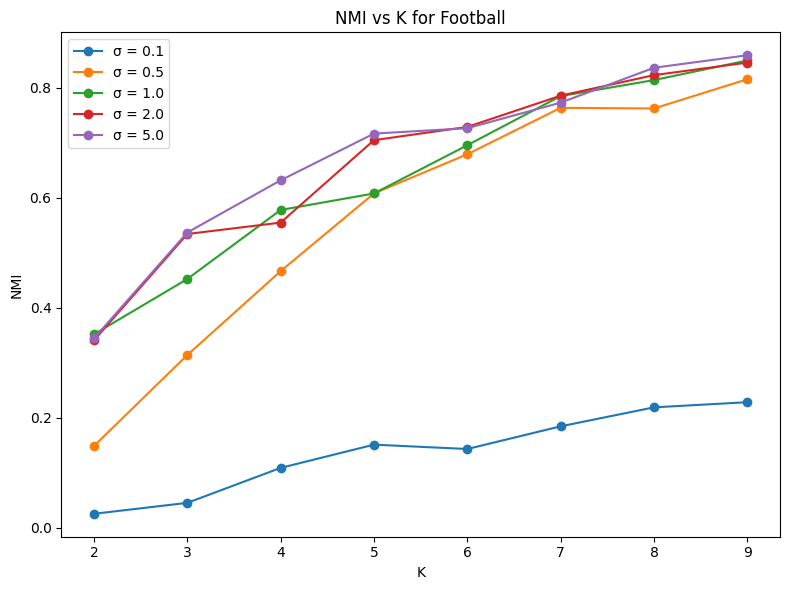

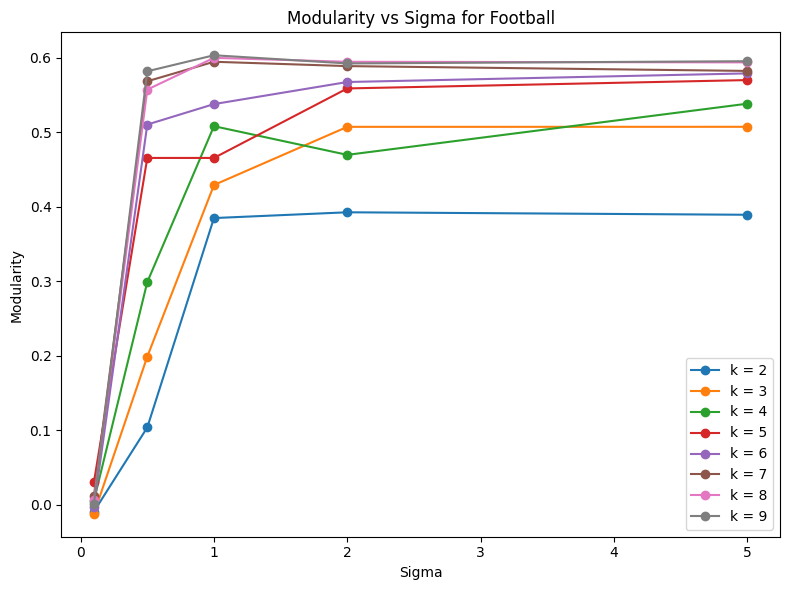

In [56]:
def plot_experiment_results(results_df, x_axis="K", metric="NMI", dataset_name="Dataset"):
    
    plt.figure(figsize=(8,6))

    if x_axis == "K":
        for sigma_val in sorted(results_df['Sigma'].unique()):
            subset = results_df[results_df['Sigma'] == sigma_val]
            plt.plot(subset['K'], subset[metric], marker='o', label=f"σ = {sigma_val}")
    elif x_axis == "Sigma":
        for k_val in sorted(results_df['K'].unique()):
            subset = results_df[results_df['K'] == k_val]
            plt.plot(subset['Sigma'], subset[metric], marker='o', label=f"k = {k_val}")

    plt.xlabel(x_axis)
    plt.ylabel(metric)
    plt.title(f"{metric} vs {x_axis} for {dataset_name}")
    plt.legend()
    plt.tight_layout()
    plt.show()
    
plot_experiment_results(results_df, x_axis="K", metric="NMI", dataset_name="Football")

plot_experiment_results(results_df, x_axis="Sigma", metric="Modularity", dataset_name="Football")